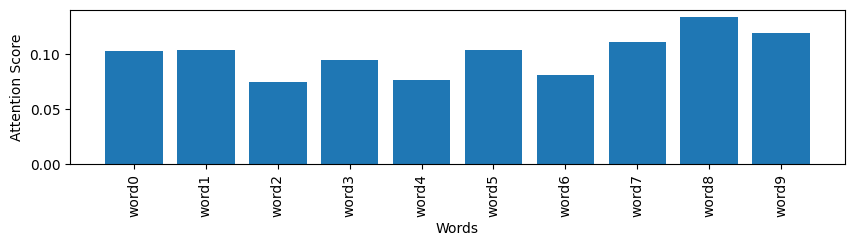

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# Set device to GPU if available
# ===============================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# Word-Level Encoder: Embeds words and encodes with a bidirectional GRU
# Input: (batch_size, seq_len)
# Output: (batch_size, seq_len, hidden_size * 2)
# ===============================
class WordEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(WordEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)  # Word embeddings
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True, bidirectional=True)  # Bi-GRU for word-level

    def forward(self, x):
        embedded = self.embedding(x)  # Convert token indices to embeddings
        output, hidden = self.rnn(embedded)  # GRU outputs sequence + final hidden states
        return output, hidden

# ===============================
# Word-Level Attention: Learns importance (weights) of each word
# Input: GRU outputs from WordEncoder
# Output: Sentence vector (weighted sum), attention weights
# ===============================
class WordAttention(nn.Module):
    def __init__(self, hidden_size):
        super(WordAttention, self).__init__()
        self.attention = nn.Linear(hidden_size * 2, 1)  # Map word vectors to scalar score

    def forward(self, rnn_output):
        scores = self.attention(rnn_output).squeeze(-1)  # Compute unnormalized attention scores
        alpha = F.softmax(scores, dim=1)  # Normalize using softmax across words
        context_vector = torch.sum(alpha.unsqueeze(-1) * rnn_output, dim=1)  # Weighted sum of word vectors
        return context_vector, alpha  # Return attended sentence vector and weights

# ===============================
# Sentence-Level Encoder: Encodes sentence vectors using Bi-GRU
# Input: (batch_size, num_sentences, hidden_size * 2)
# Output: (batch_size, num_sentences, hidden_size * 2)
# ===============================
class SentenceEncoder(nn.Module):
    def __init__(self, hidden_size):
        super(SentenceEncoder, self).__init__()
        self.rnn = nn.GRU(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)

    def forward(self, x):
        output, hidden = self.rnn(x)  # GRU over sentence vectors
        return output, hidden

# ===============================
# Sentence-Level Attention: Learns importance of each sentence in the document
# Input: Sentence representations from GRU
# Output: Document vector, attention weights over sentences
# ===============================
class SentenceAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SentenceAttention, self).__init__()
        self.attention = nn.Linear(hidden_size * 2, 1)

    def forward(self, rnn_output):
        scores = self.attention(rnn_output).squeeze(-1)  # Sentence-level attention scores
        alpha = F.softmax(scores, dim=1)  # Softmax across sentences
        context_vector = torch.sum(alpha.unsqueeze(-1) * rnn_output, dim=1)  # Document vector
        return context_vector, alpha

# ===============================
# Final Classifier: Classifies document vector into target classes
# Input: (batch_size, hidden_size * 2)
# Output: (batch_size, num_classes)
# ===============================
class DocumentClassifier(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(DocumentClassifier, self).__init__()
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Fully connected layer for classification

    def forward(self, x):
        return self.fc(x)  # Output class scores

# ===============================
# Attention Visualization Helper
# Draws a bar chart showing attention weights for each word
# ===============================
def visualize_attention(alpha, text):
    plt.figure(figsize=(10, 2))
    plt.bar(range(len(text)), alpha.detach().cpu().numpy())  # Bar chart of attention weights
    plt.xticks(range(len(text)), text, rotation=90)  # Word labels on x-axis
    plt.xlabel("Words")
    plt.ylabel("Attention Score")
    plt.show()

# ===============================
# Hyperparameters and Initialization
# ===============================
vocab_size = 5000         # Size of vocabulary
embed_size = 128          # Dimension of word embeddings
hidden_size = 64          # GRU hidden size
num_classes = 3           # Number of document classes

# Instantiate all modules and move to device
word_encoder = WordEncoder(vocab_size, embed_size, hidden_size).to(DEVICE)
word_attention = WordAttention(hidden_size).to(DEVICE)
sentence_encoder = SentenceEncoder(hidden_size).to(DEVICE)
sentence_attention = SentenceAttention(hidden_size).to(DEVICE)
document_classifier = DocumentClassifier(hidden_size, num_classes).to(DEVICE)

# ===============================
# Toy Input Sample: batch of 1 document, 5 sentences, 10 words per sentence
# (batch_size=1, num_sentences=5, num_words=10)
# ===============================
input_sample = torch.randint(0, vocab_size, (1, 5, 10)).to(DEVICE)  # Random word indices

# ===============================
# Forward Pass: Word encoding + attention, then sentence encoding + attention, then classification
# ===============================

# Step 1: Flatten to shape (5, 10) for word-level encoder (5 sentences)
word_features, _ = word_encoder(input_sample.view(-1, 10))  # Encode words in all sentences

# Step 2: Apply word-level attention to each sentence (result: 5 sentence vectors)
word_context, word_alpha = word_attention(word_features)  # Attention over words
sentence_inputs = word_context.unsqueeze(0)  # Reshape to (1, 5, hidden*2) for sentence encoder

# Step 3: Encode sentence vectors
sentence_features, _ = sentence_encoder(sentence_inputs)  # Encode with sentence-level BiGRU

# Step 4: Apply sentence-level attention
sentence_context, sentence_alpha = sentence_attention(sentence_features)  # Document vector

# Step 5: Classification based on document vector
output = document_classifier(sentence_context)  # Final classification scores

# ===============================
# Visualize attention over words in the first sentence (for demo)
# ===============================
visualize_attention(word_alpha[0], ["word" + str(i) for i in range(10)])  # Use dummy word labels


Quick Summary:

    The model builds a Hierarchical Attention Network (HAN):

        Word-level GRU + attention creates sentence vectors.

        Sentence-level GRU + attention creates a document vector.

        A final fully connected layer performs classification.